# S. Venturi - UQ Analysis of a Mass-Spring-Damper System
## Adapted from T. Oliver et al. - Validating Predicitons of Unobserved Quantities - 2014 (https://arxiv.org/abs/1404.7555)
## Case 2 (Slide Nb 20 of the Presentation, Part I): 

### In this example, the physical model of the mass-spring-damper systems follows the equation $m \ddot{x} + c \dot{x} + k x = 0$, with $m$  and $k$ equal to some constants, AND $c$ depending on the temperature, which increases with the physical body's velocity. 
### The computational model is formulated through $m \ddot{x} + c \dot{x} + k x = 0$. However, all the three coefficients are treated as constants, two of which ($c$ and $k$) are unknown and must be reconstructed from limited observations (i.e., from noisy position data sampled at discrete time steps).
### What is the amount of uncertainty that we should expect on the predicted QoIs (e.g., position and velocity)?
### How does this compare to the uncertainty from Case 1?
### How does this depend on the magnitude of the observational error?
### Can we reconstruct the observational error?

###################################################################################################################
### Note: numpy, scipy, matplotlib, theano, pymc3 libraries are required. In order to install them, type from the terminal: pip3 install library-name. 

### Import Libraries

In [5]:
from scipy.integrate import ode
import numpy
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt
from theano.compile.ops import as_op
import pymc3 as pm

### Defining Simulation Parameters (Inital Conditions and Physical Coefficients)

In [6]:
y0     = [4.0, 0.0, 20.0]
t0     = 0.0
tEnd   = 8.0
dt     = 1.0
dtData = 0.01
t      = numpy.linspace(t0, tEnd, int(tEnd)+1)

### Defining Ideal Model:     
### $m \ddot{x} + c \dot{x} + k x = 0$,    
### with 
### $\begin{cases}
      m=1.0\\
      c=c(T) = \exp \biggl( \frac{T_0}{T} - 1 \biggr), ~ ~ ~ \text{and}  ~ ~ ~ \dot{T} = c(T) \dot{x}^2 - \frac{T-T_0}{t_T} \\
      t_T = 1.0 \\
      k=3.0
    \end{cases}$
### $\begin{cases}
    x(0)=4.0 \\
    \dot{x}(0) = 0.0 \\
    T(0) = T_0 = 20.0
    \end{cases}$
### and Sampling Clean Data Points

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Original Data Points =  [4.0, 0.4025660389989435, -1.9135556475509645, 0.07536164513932006, 0.8219707327268324, -0.12599939119617984, -0.3076159087148105, 0.08109328243742872, 0.10624925667502882]


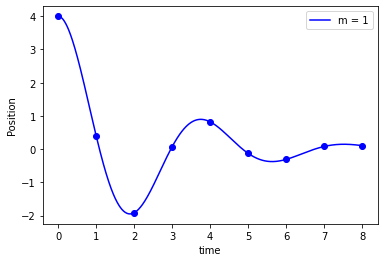

In [7]:
mOrig1 = 1.0
mOrig2 = 3.0
kOrig  = 3.0
Tt     = 1.0

# Truth System ( ~ High Fidelity Model + Noise )

def fOrig(t, y, arg1):
    return [y[1], -arg1[0]/arg1[2]*y[0] -numpy.exp(arg1[3]/y[2]-1.0)/arg1[2]*y[1], numpy.exp(arg1[3]/y[2]-1.0)*y[1]**2 - (y[2]-arg1[3])/arg1[4] ]

def jacOrig(t, y, arg1):
    return [ [0.0, 1.0, 0.0], [-arg1[0]/arg1[2], -numpy.exp(arg1[3]/y[2]-1.0)/arg1[2], y[1]/arg1[2]*(arg1[3]*numpy.exp(arg1[3]/y[2]-1.0)/y[2]**2)], [0.0, 2.0*numpy.exp(arg1[3]/y[2]-1.0), y[1]**2*numpy.exp(arg1[3]/y[2]-1.0)*arg1[3]/y[2]**2 - 1.0/arg1[4]] ]

# For Mass = 1
rOrig1 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
rOrig1.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig1, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig1, y0[2], Tt])
tDataPlot = []
xDataPlot = []
vDataPlot = []
tDataPlot.append(t0)
xDataPlot.append(y0[0])
vDataPlot.append(y0[1])
while rOrig1.successful() and rOrig1.t <= tEnd:
    rOrig1.integrate(rOrig1.t+dtData)
    tDataPlot.append(rOrig1.t)
    xDataPlot.append(numpy.real(rOrig1.y[0]))
    vDataPlot.append(numpy.real(rOrig1.y[1]))

## For Mass = 2
#rOrig2 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
#rOrig2.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig2, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig2, y0[2], Tt])
#tDataPlot.append(t0)
#xDataPlot.append(y0[0])
#vDataPlot.append(y0[1])
#while rOrig2.successful() and rOrig2.t <= tEnd:
#    rOrig2.integrate(rOrig2.t+dtData)
#    tDataPlot.append(rOrig2.t)
#    xDataPlot.append(numpy.real(rOrig2.y[0]))
#    vDataPlot.append(numpy.real(rOrig2.y[1]))


# For Mass = 1
rOrig1 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
rOrig1.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig1, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig1, y0[2], Tt])
tData = []
xData = []
vData = []
tData.append(t0)
xData.append(y0[0])
vData.append(y0[1])
while rOrig1.successful() and rOrig1.t < tEnd:
    rOrig1.integrate(rOrig1.t+dt)
    tData.append(rOrig1.t)
    xData.append(numpy.real(rOrig1.y[0]))
    vData.append(numpy.real(rOrig1.y[1]))

## For Mass = 2
#rOrig2 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
#rOrig2.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig2, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig2, y0[2], Tt])
#while rOrig2.successful() and rOrig2.t < tEnd:
#    rOrig2.integrate(rOrig2.t+dt)
#    tData.append(rOrig2.t)
#    xData.append(numpy.real(rOrig2.y[0]))
#    vData.append(numpy.real(rOrig2.y[1]))

#xData = numpy.array([4.0, 4.056287e-1, -1.917800, 7.331597e-2, 8.176825e-1, -1.129453e-1, -3.011407e-1, 9.303637e-2, 8.884368e-2])#, ...
##                     1.705548, -1.634634, -2.127946, -12.8128642e-1, 1.269814, 8.507498e-1, -3.259694e-1, -7.080865e-1])
#HalfLength     = int(numpy.size(tData)/2)
#HalfLengthPlot = int(numpy.size(tDataPlot)/2)

print('Original Data Points = ', xData)
line1, = plt.plot(tDataPlot, xDataPlot,'b')
#line1, = plt.plot(tDataPlot[0:HalfLengthPlot-1],xDataPlot[0:HalfLengthPlot-1],'b')
line1.set_label('m = 1')
plt.plot(tData,xData,'bo')
#plt.plot(tData[0:HalfLength-1],xData[0:HalfLength-1],'bo')
#line2, = plt.plot(tDataPlot[HalfLengthPlot:-1],xDataPlot[HalfLengthPlot:-1],'g')
#line2.set_label('m = 2')
#plt.plot(tData[HalfLength:-1],xData[HalfLength:-1],'go')
plt.xlabel('time')
plt.ylabel('Position')
plt.legend()
plt.savefig('Case2_Data', format='eps')
plt.show()


### Defining Ideal Model with Noise:    
### $m \ddot{x} + c \dot{x} + k x = 0$,    
### with 
### $\begin{cases}
      m=1.0\\
      c=c(T) = \exp \biggl( \frac{T_0}{T} - 1 \biggr), ~ ~ ~ \text{and}  ~ ~ ~ \dot{T} = c(T) \dot{x}^2 - \frac{T-T_0}{t_T} \\
      t_T = 1.0 \\
      k=3.0
    \end{cases}$
### $\begin{cases}
    x(0)=4.0 \\
    \dot{x}(0) = 0.0 \\
    T(0) = T_0 = 20.0
    \end{cases}$
    
### and Additive Noise: 
### $\epsilon \sim \mathcal{N}(0, \sigma_N^2 = 0.1^2)$;
### Sampling Noisy Data Points

Noisy Data Points =  [4.0, 0.4955163016714096, -1.984857727731458, 0.03799918276488392, 0.7903389518511088, -0.04874818785858029, -0.3036552964369439, -0.015015464723902222, 0.01973740585917426]


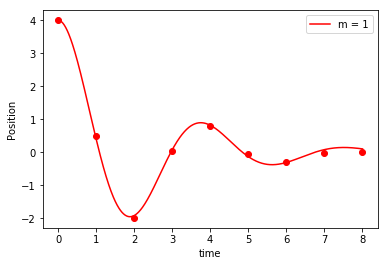

In [54]:
mOrig1 = 1.0
mOrig2 = 3.0
kOrig  = 3.0
Tt     = 1.0
SigmaN = 0.1

# Truth System ( ~ High Fidelity Model + Noise )

def fOrig(t, y, arg1):
    return [y[1], -arg1[0]/arg1[2]*y[0] -numpy.exp(arg1[3]/y[2]-1.0)/arg1[2]*y[1], numpy.exp(arg1[3]/y[2]-1.0)*y[1]**2 - (y[2]-arg1[3])/arg1[4] ]

def jacOrig(t, y, arg1):
    return [ [0.0, 1.0, 0.0], [-arg1[0]/arg1[2], -numpy.exp(arg1[3]/y[2]-1.0)/arg1[2], y[1]/arg1[2]*(arg1[3]*numpy.exp(arg1[3]/y[2]-1.0)/y[2]**2)], [0.0, 2.0*numpy.exp(arg1[3]/y[2]-1.0), y[1]**2*numpy.exp(arg1[3]/y[2]-1.0)*arg1[3]/y[2]**2 - 1.0/arg1[4]] ]

# For Mass = 1
rOrig1 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
rOrig1.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig1, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig1, y0[2], Tt])
tDataNoisePlot = []
xDataNoisePlot = []
vDataNoisePlot = []
tDataNoisePlot.append(t0)
xDataNoisePlot.append(y0[0])
vDataNoisePlot.append(y0[1])
while rOrig1.successful() and rOrig1.t <= tEnd:
    rOrig1.integrate(rOrig1.t+dtData)
    tDataNoisePlot.append(rOrig1.t)
    xDataNoisePlot.append(numpy.real(rOrig1.y[0]))
    vDataNoisePlot.append(numpy.real(rOrig1.y[1]))

## For Mass = 2
#rOrig2 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
#rOrig2.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig2, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig2, y0[2], Tt])
#tDataNoisePlot.append(t0)
#xDataNoisePlot.append(y0[0])
#vDataNoisePlot.append(y0[1])
#while rOrig2.successful() and rOrig2.t <= tEnd:
#    rOrig2.integrate(rOrig2.t+dtData)
#    tDataNoisePlot.append(rOrig2.t)
#    xDataNoisePlot.append(numpy.real(rOrig2.y[0]))
#    vDataNoisePlot.append(numpy.real(rOrig2.y[1]))


# For Mass = 1
rOrig1 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
rOrig1.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig1, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig1, y0[2], Tt])
tDataNoise = []
xDataNoise = []
vDataNoise = []
tDataNoise.append(t0)
xDataNoise.append(y0[0])
vDataNoise.append(y0[1])
while rOrig1.successful() and rOrig1.t < tEnd:
    rOrig1.integrate(rOrig1.t+dt)
    tDataNoise.append(rOrig1.t)
    xDataNoise.append(numpy.real(rOrig1.y[0]))
    vDataNoise.append(numpy.real(rOrig1.y[1]))

xNoise         = numpy.random.normal(0.0, SigmaN, 8)
xDataNoise[1:] = xDataNoise[1:] + xNoise

## For Mass = 2
#rOrig2 = ode(fOrig, jacOrig).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
#rOrig2.set_initial_value(y0, t0).set_f_params([kOrig, 0.0, mOrig2, y0[2], Tt]).set_jac_params([kOrig, 0.0, mOrig2, y0[2], Tt])
#while rOrig2.successful() and rOrig2.t < tEnd:
#    rOrig2.integrate(rOrig2.t+dt)
#    tDataNoise.append(rOrig2.t)
#    xDataNoise.append(numpy.real(rOrig2.y[0]))
#    vDataNoise.append(numpy.real(rOrig2.y[1]))

#xDataNoise = numpy.array([4.0, 4.056287e-1, -1.917800, 7.331597e-2, 8.176825e-1, -1.129453e-1, -3.011407e-1, 9.303637e-2, 8.884368e-2])#, ...
##                     1.705548, -1.634634, -2.127946, -12.8128642e-1, 1.269814, 8.507498e-1, -3.259694e-1, -7.080865e-1])
#HalfLength     = int(numpy.size(tDataNoise)/2)
#HalfLengthPlot = int(numpy.size(tDataNoisePlot)/2)

print('Noisy Data Points = ', xDataNoise)
line1, = plt.plot(tDataNoisePlot, xDataNoisePlot,'r')
#line1, = plt.plot(tDataPlot[0:HalfLengthPlot-1],xDataPlot[0:HalfLengthPlot-1],'b')
line1.set_label('m = 1')
plt.plot(tDataNoise,xDataNoise,'ro')
#plt.plot(tData[0:HalfLength-1],xData[0:HalfLength-1],'bo')
#line2, = plt.plot(tDataPlot[HalfLengthPlot:-1],xDataPlot[HalfLengthPlot:-1],'g')
#line2.set_label('m = 2')
#plt.plot(tData[HalfLength:-1],xData[HalfLength:-1],'go')
plt.xlabel('time')
plt.ylabel('Position')
plt.legend()
plt.savefig('Case2_NoisyData', format='eps')
plt.show()

### Defining Computational Model (i.e., Some Missing Physics Represented through Uncertain Coefficients):
### $m \ddot{x} + c \dot{x} + k x = 0$,    
### with 
### $\begin{cases}
      m=1.0\\
      c= ?\\
      k= ?\\
    \end{cases}$
### $\begin{cases}
    x(0)=4.0 \\
    \dot{x}(0) = 0.0 \\
    \end{cases}$
    
### and Additive Noise: 
### $\epsilon \sim \mathcal{N}(0, \sigma_L^2)$

In [8]:
# Model Form
@as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dvector])
def th_forward_model(param1, param2):
    y0, t0 = [4.0, 0.0], 0.0
    tEnd   = 8.0
    dt     = 1.0
    def f(t, y, arg1):
        return [y[1], -arg1[0]/arg1[2]*y[0]-arg1[1]/arg1[2]*y[1]]
    def jac(t, y, arg1):
        return [[0.0, 1.0], [-arg1[0]/arg1[2], -arg1[1]/arg1[2]]]
    tPred = []
    xPred = []
    vPred = []
    tPred.append(t0)
    xPred.append(y0[0])
    vPred.append(y0[1])
    r1 = ode(f, jac).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
    r1.set_initial_value(y0, t0).set_f_params([param1, param2, 1.0]).set_jac_params([param1, param2, 1.0])
    while r1.successful() and r1.t < tEnd:
        r1.integrate(r1.t+dt)
        tPred.append(r1.t)
        xPred.append(numpy.real(r1.y[0]))
        vPred.append(numpy.real(r1.y[1]))
    #r2 = ode(f, jac).set_integrator('vode', method='Adams', with_jacobian=True, atol=1.e-20)
    #r2.set_initial_value(y0, t0).set_f_params([param1, param2, 2.0]).set_jac_params([param1, param2, 2.0])
    #while r2.successful() and r2.t < tEnd:
    #    r2.integrate(r2.t+dt)
    #    tPred.append(r2.t)
    #    xPred.append(numpy.real(r2.y[0]))
    #    vPred.append(numpy.real(r2.y[1]))
    xPred = numpy.array(xPred)
    th_states = xPred
    return th_states

##############################################################################################################
### Case 2.1: Reconstructing $k$ and $c$ from the Clean Data
### Note: $\sigma_L$ is fixed to $\sigma_L = 0.01$

In [9]:
### Model 1
Model1 = pm.Model()

# Model Construction
with Model1:
    K1     = pm.Normal('K1',    1.0, numpy.sqrt(0.5))
    c1     = pm.Lognormal('c1', 0.0, numpy.sqrt(0.5))
    xPred1 = th_forward_model(K1, c1)
    x1At0  = pm.Deterministic('x1@0',xPred1[0])
    x1At1  = pm.Deterministic('x1@1',xPred1[1])
    x1At2  = pm.Deterministic('x1@2',xPred1[2])
    x1At3  = pm.Deterministic('x1@3',xPred1[3])
    x1At4  = pm.Deterministic('x1@4',xPred1[4])
    x1At5  = pm.Deterministic('x1@5',xPred1[5])
    x1At6  = pm.Deterministic('x1@6',xPred1[6])
    x1At7  = pm.Deterministic('x1@7',xPred1[7])
    x1At8  = pm.Deterministic('x1@8',xPred1[8])
    Sigma1 = 1.e-2
    yLike1 = pm.Normal('yLike1', mu=xPred1, sd=Sigma1, observed=xData)

# Model Calibration with Perfect Data
with Model1:
    trace1 = pm.sample(5000, step=pm.Metropolis(), tune=1000, cores=4)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [c1]
>Metropolis: [K1]


KeyboardInterrupt: 

In [ ]:
# Plot Parameter Posterior Distributions
with Model1:
    trarr = pm.traceplot(trace1, varnames=['K1','c1'], lines={'K1':3.0} );
    plt.savefig('Case2_Model1_ParamsPosts', format='eps')
    plt.show()

In [ ]:
# Print Statistics
with Model1:
    print(pm.summary(trace1))

In [ ]:
# Plot Output Posterior Distributions
with Model1:
    trarr = pm.traceplot(trace1, varnames=['x1@1','x1@2','x1@3','x1@4', 'x1@5','x1@6','x1@7','x1@8'], 
                  lines={'x1@1': xData[1], 'x1@2': xData[2], 'x1@3': xData[3], 'x1@4': xData[4], 'x1@5': xData[5], 'x1@6': xData[6], 'x1@7': xData[7], 'x1@8': xData[8]} );
    plt.savefig('Case2_Model1_OutputPosts', format='eps')
    plt.show()

##############################################################################################################
### Case 2.2: Reconstructing $k$ and $c$ from the Clean Data
### Note: $\sigma_L$ gets Calibrated as well

In [62]:
# Model 2
Model2 = pm.Model()

# Model Construction
with Model2:
    K2     = pm.Normal('K2',    1.0, numpy.sqrt(0.5))
    c2     = pm.Lognormal('c2', 0.0, numpy.sqrt(0.5))
    xPred2 = th_forward_model(K2, c2)
    x2At0  = pm.Deterministic('x2@0',xPred2[0])
    x2At1  = pm.Deterministic('x2@1',xPred2[1])
    x2At2  = pm.Deterministic('x2@2',xPred2[2])
    x2At3  = pm.Deterministic('x2@3',xPred2[3])
    x2At4  = pm.Deterministic('x2@4',xPred2[4])
    x2At5  = pm.Deterministic('x2@5',xPred2[5])
    x2At6  = pm.Deterministic('x2@6',xPred2[6])
    x2At7  = pm.Deterministic('x2@7',xPred2[7])
    x2At8  = pm.Deterministic('x2@8',xPred2[8])
    Sigma2 = pm.Lognormal('Sigma2', 0.0, 1.0)
    yLike2 = pm.Normal('yLike2', mu=xPred2, sd=Sigma2, observed=xData)

# Model Calibration with Perfect Data
with Model2:
    trace2 = pm.sample(5000, step=pm.Metropolis(), tune=1000, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Sigma2]
>Metropolis: [c2]
>Metropolis: [K2]
Sampling 4 chains: 100%|██████████| 24000/24000 [01:43<00:00, 232.97draws/s]
The number of effective samples is smaller than 10% for some parameters.


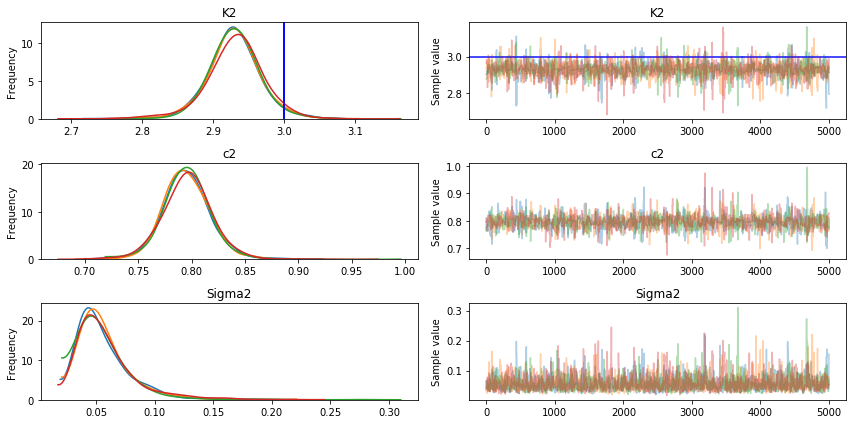

In [64]:
# Plot Parameter Posterior Distributions
with Model2:
    trarr = pm.traceplot(trace2, varnames=['K2','c2', 'Sigma2'], lines={'K2': 3.0} );
    plt.savefig('Case2_Model2_ParamPosts', format='eps')
    plt.show()

In [65]:
# Print Statistics
with Model2:
    print(pm.summary(trace2))

            mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
K2      2.929791  0.037697  0.000831  2.853545  3.005403  1918.680419   
c2      0.795734  0.022137  0.000525  0.755338  0.842271  1848.261863   
x2@0    4.000000  0.000000  0.000000  4.000000  4.000000          NaN   
x2@1    0.387268  0.033306  0.000518  0.323192  0.455091  3464.957105   
x2@2   -1.853780  0.038523  0.000904 -1.925612 -1.774162  1890.228605   
x2@3    0.058760  0.040595  0.000696 -0.022049  0.139205  3001.516562   
x2@4    0.829144  0.035938  0.000890  0.757828  0.900307  1671.734512   
x2@5   -0.130874  0.029640  0.000479 -0.187109 -0.069204  3288.782524   
x2@6   -0.357712  0.025008  0.000637 -0.409144 -0.310366  1551.940810   
x2@7    0.104047  0.018308  0.000278  0.067228  0.140488  3588.730434   
x2@8    0.148356  0.015351  0.000395  0.116323  0.177133  1501.274385   
Sigma2  0.056487  0.024253  0.000632  0.023848  0.102462  1346.725238   

            Rhat  
K2      1.000584  
c2      1.00

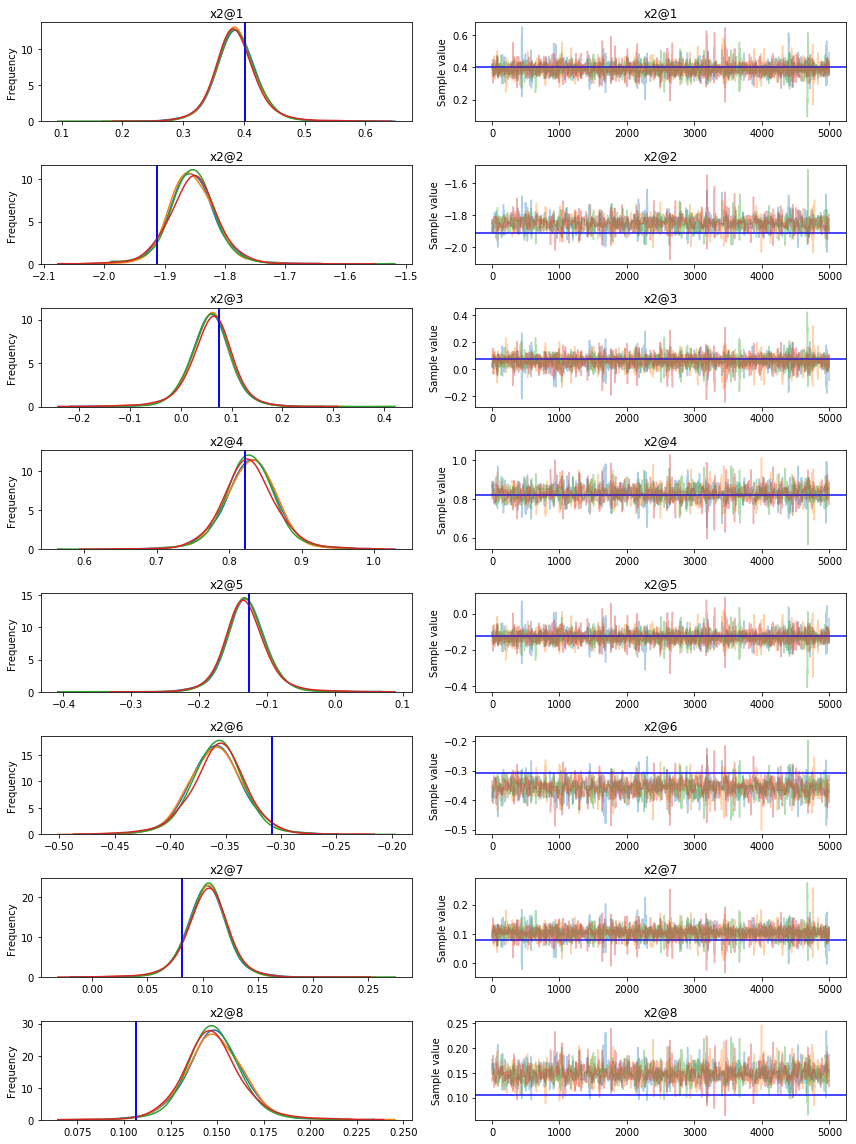

In [66]:
# Plot Output Posterior Distributions
with Model2:
    trarr = pm.traceplot(trace2, varnames=['x2@1','x2@2','x2@3','x2@4', 'x2@5','x2@6','x2@7','x2@8'], 
                  lines={'x2@1': xData[1], 'x2@2': xData[2], 'x2@3': xData[3], 'x2@4': xData[4], 'x2@5': xData[5], 'x2@6': xData[6], 'x2@7': xData[7], 'x2@8': xData[8]} );
    plt.savefig('Case2_Model2_OutputPosts', format='eps')
    plt.show()

##############################################################################################################
### Case 2.3: Reconstructing $k$ and $c$ from the Noisy Data
### Note: $\sigma_L$ gets Calibrated as well

In [67]:
# Model 3
Model3 = pm.Model()

# Model Construction
with Model3:
    K3     = pm.Normal('K3',    1.0, numpy.sqrt(0.5))
    c3     = pm.Lognormal('c3', 0.0, numpy.sqrt(0.5))
    xPred3 = th_forward_model(K3, c3)
    x3At0  = pm.Deterministic('x3@0',xPred3[0])
    x3At1  = pm.Deterministic('x3@1',xPred3[1])
    x3At2  = pm.Deterministic('x3@2',xPred3[2])
    x3At3  = pm.Deterministic('x3@3',xPred3[3])
    x3At4  = pm.Deterministic('x3@4',xPred3[4])
    x3At5  = pm.Deterministic('x3@5',xPred3[5])
    x3At6  = pm.Deterministic('x3@6',xPred3[6])
    x3At7  = pm.Deterministic('x3@7',xPred3[7])
    x3At8  = pm.Deterministic('x3@8',xPred3[8])
    Sigma3 = pm.Lognormal('Sigma3', 0.0, 1.0)
    yLike3 = pm.Normal('yLike3', mu=xPred3, sd=Sigma3, observed=xDataNoise)

# Model Calibration with Noisy Data
with Model3:
    trace3 = pm.sample(5000, step=pm.Metropolis(), tune=1000, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Sigma3]
>Metropolis: [c3]
>Metropolis: [K3]
Sampling 4 chains: 100%|██████████| 24000/24000 [01:30<00:00, 263.89draws/s]
The number of effective samples is smaller than 10% for some parameters.


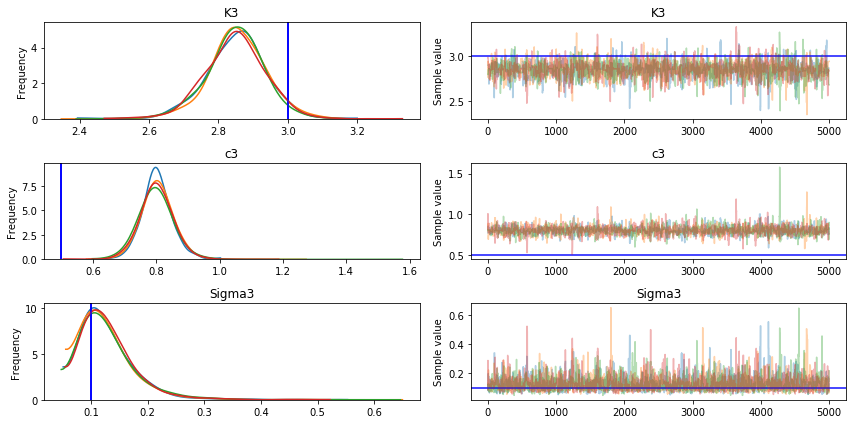

In [68]:
# Plot Parameter Posterior Distributions
with Model3:
    trarr = pm.traceplot(trace3, varnames=['K3', 'c3', 'Sigma3'], lines={'K3': 3.0, 'c3': 0.5, 'Sigma3': SigmaL});
    plt.savefig('Case2_Model3_ParamPosts', format='eps')
    plt.show()

In [69]:
# Print Statistics
with Model3:
    print(pm.summary(trace3))

            mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
K3      2.851597  0.085102  0.001798  2.687480  3.024507  1920.106215   
c3      0.802331  0.050027  0.001079  0.706529  0.900125  2151.794733   
x3@0    4.000000  0.000000  0.000000  4.000000  4.000000          NaN   
x3@1    0.467894  0.074015  0.001223  0.322799  0.617454  3217.542847   
x3@2   -1.836341  0.085853  0.001831 -2.003192 -1.667374  2272.089277   
x3@3   -0.040234  0.091134  0.001669 -0.224875  0.135903  2598.724079   
x3@4    0.826947  0.079132  0.001779  0.679280  0.991497  2037.001859   
x3@5   -0.057736  0.066841  0.001203 -0.185435  0.078466  2726.647221   
x3@6   -0.365486  0.055000  0.001278 -0.469087 -0.253676  1890.478037   
x3@7    0.059126  0.041352  0.000722 -0.024381  0.139058  2957.685305   
x3@8    0.158514  0.034074  0.000805  0.093354  0.224479  1787.750533   
Sigma3  0.128017  0.048902  0.001149  0.055681  0.216103  1554.208391   

            Rhat  
K3      1.000819  
c3      1.00

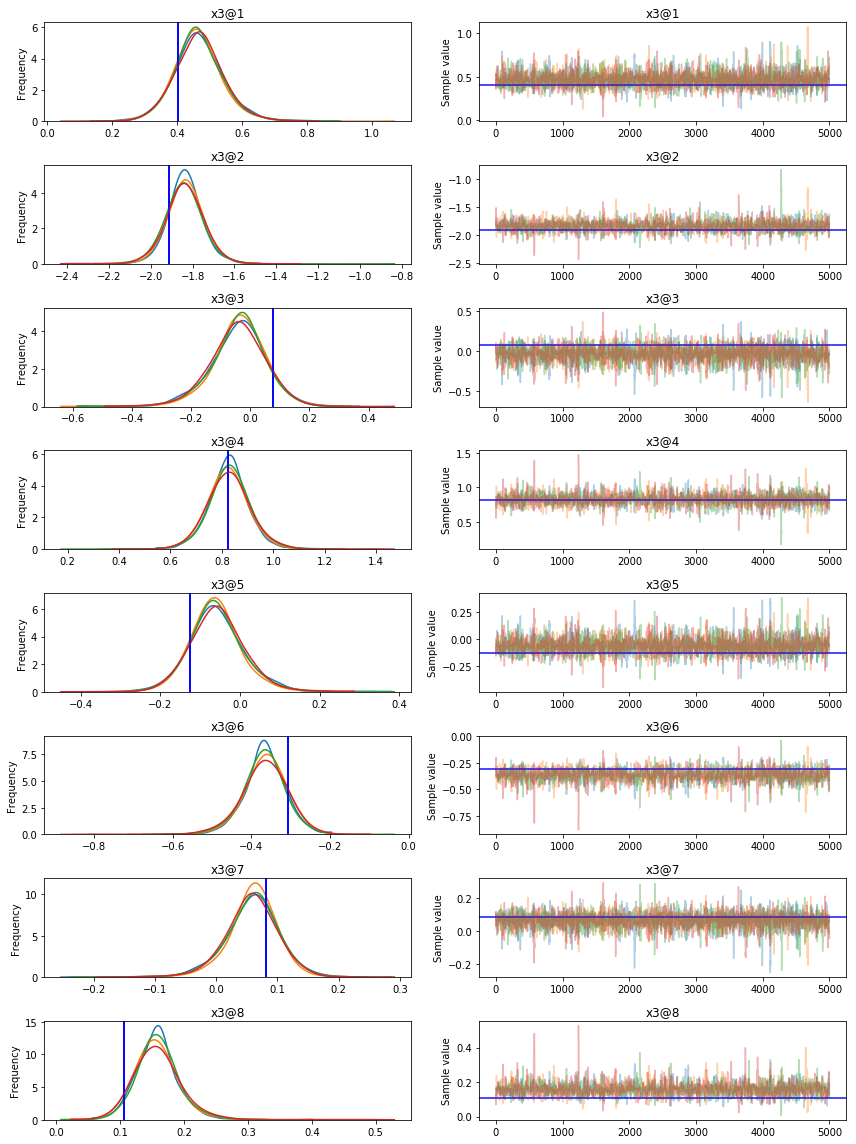

In [70]:
# Plot Output Posterior Distributions
with Model3:
    trarr = pm.traceplot(trace3, varnames=['x3@1','x3@2','x3@3','x3@4', 'x3@5','x3@6','x3@7','x3@8'], 
                  lines={'x3@1': xData[1], 'x3@2': xData[2], 'x3@3': xData[3], 'x3@4': xData[4], 'x3@5': xData[5], 'x3@6': xData[6], 'x3@7': xData[7], 'x3@8': xData[8]} );
    plt.savefig('Case2_Model3_OutputPosts', format='eps')
    plt.show()